# Section 2 : Hyperparameters
This section aims to perform a hyperparameter search to improve the performance of a custom model that distinguishes between any three classes.


## Task 1: Hyperparameter Optimization 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from autogluon.tabular import TabularPredictor
#few libraries may be redundant

/Users/aryan/Desktop/Academics /Semester 4/AI Software tools and techniques/-CS-203-MLP-Model-Implementation-Experiment-Tracking-Hyperparameters/venv_alt/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(3407)
np.random.seed(3407)

In [3]:
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)  

#One-hot encoding
ohe = OneHotEncoder(sparse_output=False)
y_onehot = ohe.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [4]:
#Define MLP model class
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_units, output_size):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, hidden_units)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_units, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

#Training function with hyperparameter tuning
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, torch.max(y_batch, 1)[1])
            loss.backward()
            optimizer.step()
    
    #Evaluate
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            y_pred.extend(torch.argmax(outputs, axis=1).numpy())
            y_true.extend(torch.argmax(y_batch, axis=1).numpy())
    
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, f1, y_true, y_pred

## Task 1 : Hyperparameter Optimization 
### Manual Hyper-parameter Search - Brute Force

Batch Size: 2, LR: 0.001, Epochs: 1 -> Accuracy: 0.9333, F1: 0.9319


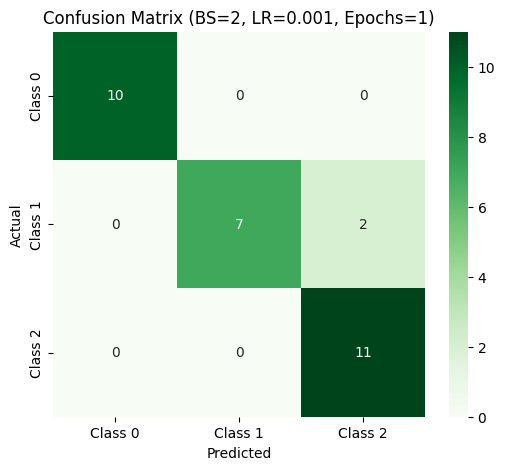

Sample Predictions:

Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 1, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 1, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 2, Truth: 1


Batch Size: 2, LR: 0.001, Epochs: 3 -> Accuracy: 0.9667, F1: 0.9664


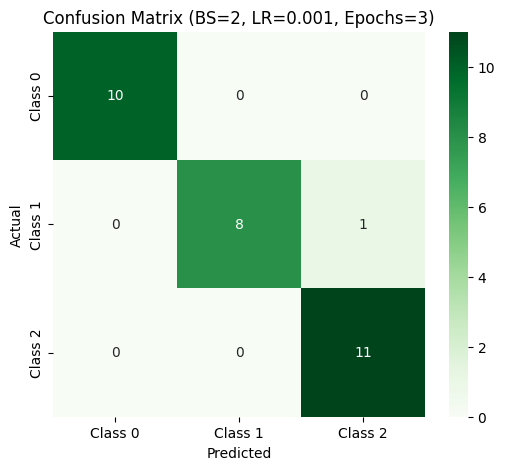

Sample Predictions:

Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 1, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 1, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 1, Truth: 1


Batch Size: 2, LR: 0.001, Epochs: 5 -> Accuracy: 0.9667, F1: 0.9664


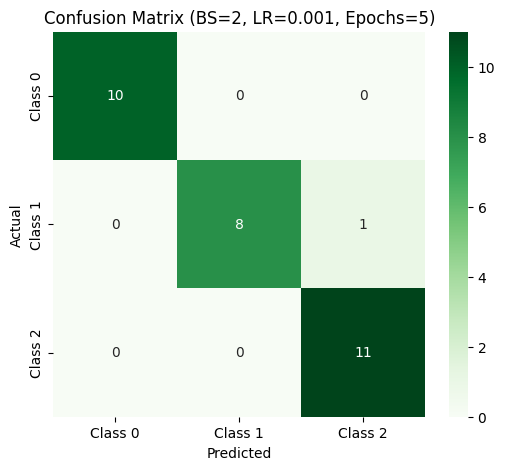

Sample Predictions:

Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 1, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 1, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 1, Truth: 1


Batch Size: 2, LR: 1e-05, Epochs: 1 -> Accuracy: 0.7333, F1: 0.6556


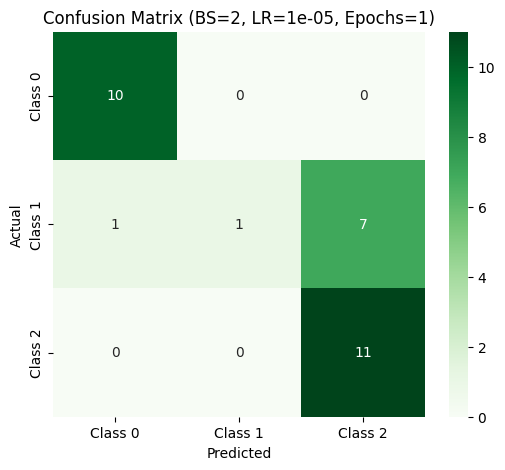

Sample Predictions:

Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 2, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 2, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 2, Truth: 1


Batch Size: 2, LR: 1e-05, Epochs: 3 -> Accuracy: 0.8000, F1: 0.7714


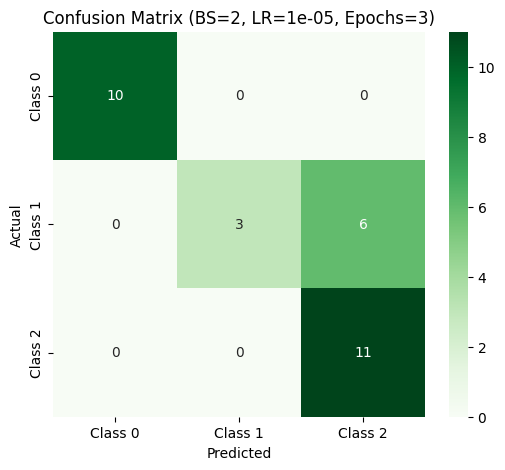

Sample Predictions:

Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 2, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 2, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 2, Truth: 1


Batch Size: 2, LR: 1e-05, Epochs: 5 -> Accuracy: 0.9333, F1: 0.9319


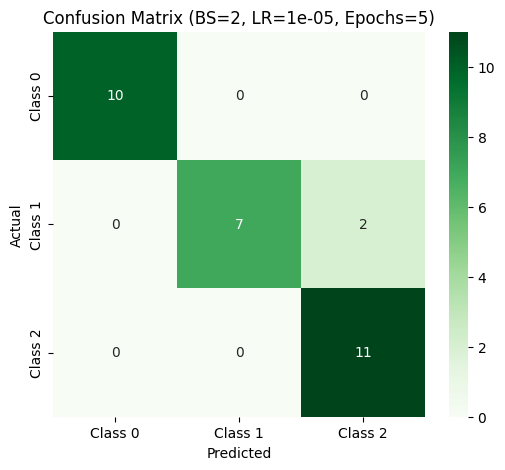

Sample Predictions:

Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 1, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 1, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 2, Truth: 1


Batch Size: 4, LR: 0.001, Epochs: 1 -> Accuracy: 1.0000, F1: 1.0000


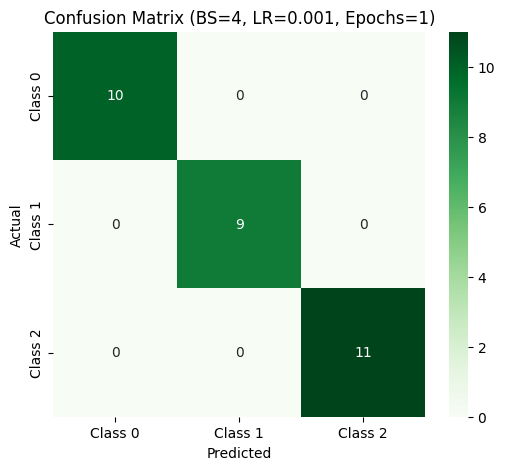

Sample Predictions:

Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 1, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 1, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 1, Truth: 1


Batch Size: 4, LR: 0.001, Epochs: 3 -> Accuracy: 1.0000, F1: 1.0000


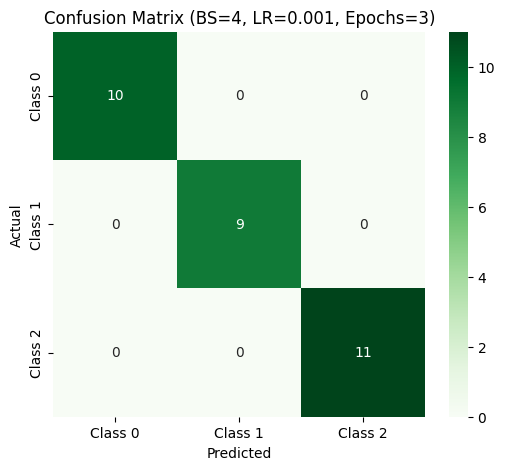

Sample Predictions:

Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 1, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 1, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 1, Truth: 1


Batch Size: 4, LR: 0.001, Epochs: 5 -> Accuracy: 1.0000, F1: 1.0000


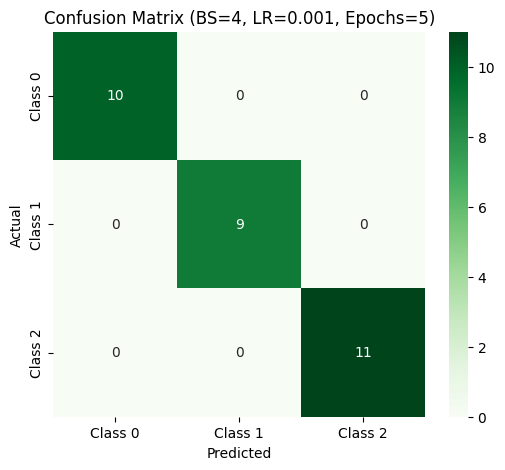

Sample Predictions:

Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 1, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 1, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 1, Truth: 1


Batch Size: 4, LR: 1e-05, Epochs: 1 -> Accuracy: 0.8000, F1: 0.7633


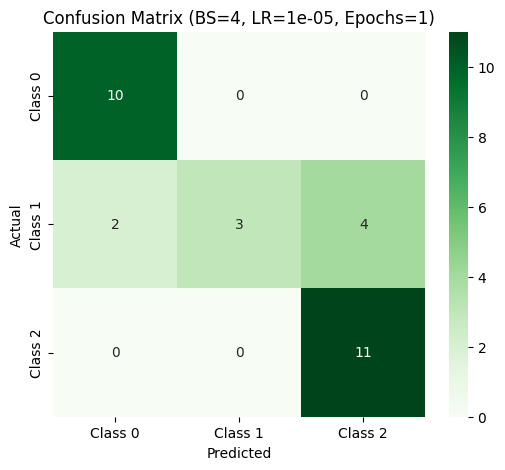

Sample Predictions:

Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 2, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 2, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 2, Truth: 1


Batch Size: 4, LR: 1e-05, Epochs: 3 -> Accuracy: 0.9333, F1: 0.9319


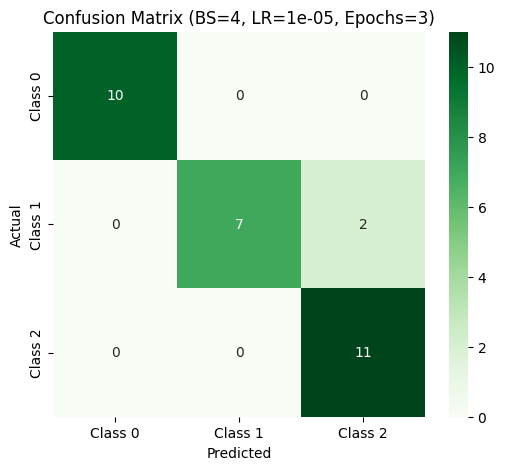

Sample Predictions:

Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 1, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 1, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 2, Truth: 1


Batch Size: 4, LR: 1e-05, Epochs: 5 -> Accuracy: 0.9333, F1: 0.9319


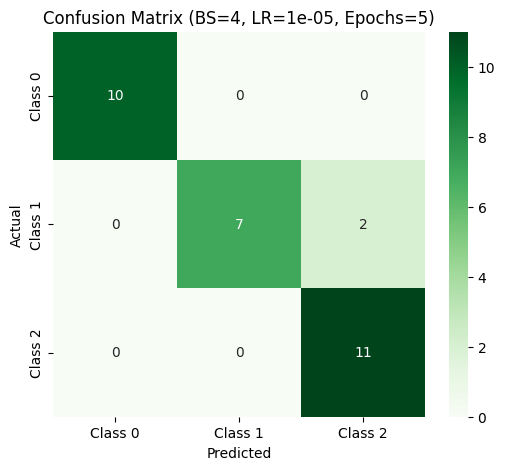

Sample Predictions:

Input: [ 0.31099755 -0.592373    0.53540856  0.00087755], Prediction: 1, Truth: 1
Input: [-0.17367394  1.7095946  -1.1697142  -1.1838121 ], Prediction: 0, Truth: 0
Input: [ 2.2496834 -1.0527666  1.7858319  1.4488316], Prediction: 2, Truth: 2
Input: [ 0.18982966 -0.36217624  0.4217337   0.3957741 ], Prediction: 1, Truth: 1
Input: [ 1.1591727  -0.592373    0.592246    0.26414192], Prediction: 2, Truth: 1




In [5]:
#Hyperparameter search
batch_sizes = [2, 4]
learning_rates = [1e-3, 1e-5]
epochs_list = [1, 3, 5]

results = []

for batch_size in batch_sizes:
    for lr in learning_rates:
        for epochs in epochs_list:
            # Prepare DataLoader
            train_dataset = TensorDataset(X_train, y_train)
            test_dataset = TensorDataset(X_test, y_test)
            train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
            
            # Initialize model, loss, optimizer
            model = MLPModel(input_size=4, hidden_units=500, output_size=3)
            criterion = nn.CrossEntropyLoss()
            optimizer = optim.Adam(model.parameters(), lr=lr)
            
            # Train and evaluate
            accuracy, f1, y_true, y_pred = train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs)
            
            # Store results
            results.append((batch_size, lr, epochs, accuracy, f1))
            print(f'Batch Size: {batch_size}, LR: {lr}, Epochs: {epochs} -> Accuracy: {accuracy:.4f}, F1: {f1:.4f}')
            
            # Confusion matrix
            cm = confusion_matrix(y_true, y_pred)
            plt.figure(figsize=(6, 5))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.title(f"Confusion Matrix (BS={batch_size}, LR={lr}, Epochs={epochs})")
            plt.show()
            
            # Show 5 test samples
            print("Sample Predictions:\n")
            for i in range(5):
                print(f"Input: {X_test[i].numpy()}, Prediction: {y_pred[i]}, Truth: {y_true[i]}")
            print("\n")




### Analysis of Brute Force Approach

In [6]:
df = pd.DataFrame(results, columns=["Batch Size", "Learning Rate", "Epochs", "Accuracy", "F1"])
df["Accuracy"] = df["Accuracy"]*100
print("\nHyperparameter Search Results:")
df


Hyperparameter Search Results:


,Batch Size,Learning Rate,Epochs,Accuracy,F1
0,2,0.00100,1,93.333333,0.931944
1,2,0.00100,3,96.666667,0.966411
2,2,0.00100,5,96.666667,0.966411
3,2,0.00001,1,73.333333,0.655621
4,2,0.00001,3,80.000000,0.771429
5,2,0.00001,5,93.333333,0.931944
6,4,0.00100,1,100.000000,1.000000
7,4,0.00100,3,100.000000,1.000000
8,4,0.00100,5,100.000000,1.000000
9,4,0.00001,1,80.000000,0.763287


In [7]:
best_params = df.loc[df["Accuracy"].idxmax()]
print(f"\nBest Hyperparameters: Batch Size={best_params['Batch Size']}, Learning Rate={best_params['Learning Rate']}, Epochs={best_params['Epochs']} -> Accuracy={best_params['Accuracy']:.4f}, F1={best_params['F1']:.4f}")


Best Hyperparameters: Batch Size=4.0, Learning Rate=0.001, Epochs=1.0 -> Accuracy=100.0000, F1=1.0000


In [8]:
# !pip install autogluon
# we downloaded this via pip in the terminal 

## Task 2 : Automated Hyperparameter Search

Grid Search → Try all combinations.

Random Search → Pick a random subset.

Hyperband → Allocate resources dynamically.

Bayesian Optimization → Use past results to guide future choices.

In [19]:
from autogluon.tabular import TabularPredictor
import random
import os
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor
from itertools import product
import pandas as pd
import numpy as np

In [10]:
from autogluon.common import space #this helps us define relu

In [11]:
# Load dataset
iris = load_iris()
X = iris.data
y = iris.target.reshape(-1, 1)  # Reshape for one-hot encoding

# One-hot encoding
ohe = OneHotEncoder(sparse_output=False)
y_onehot = ohe.fit_transform(y)

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_onehot, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Convert to DataFrames
train_df = pd.DataFrame(X_train.numpy(), columns=["feature_0", "feature_1", "feature_2", "feature_3"])
train_df["target"] = np.argmax(y_train.numpy(), axis=1)

test_df = pd.DataFrame(X_test.numpy(), columns=["feature_0", "feature_1", "feature_2", "feature_3"])
test_df["target"] = np.argmax(y_test.numpy(), axis=1)

In [20]:
os.makedirs("logs", exist_ok=True)

Here, we ensure that we use the same model architecture as we have used above

#### Train function made based on **Autogluon Document**

In [12]:
def train_model_task2(model_name, nn_options, train_df, metric, log_file):
    """Trains AutoGluon's TabularPredictor and logs results."""
    from autogluon.tabular import TabularPredictor

    predictor = TabularPredictor(label='target', 
                                 path=f'./models/{model_name}', 
                                 eval_metric=metric).fit(train_df, 
                                                         hyperparameters={'NN_TORCH': nn_options})
    
    # Evaluate
    predictions = predictor.predict(test_df)
    y_true = test_df["target"].values
    acc = accuracy_score(y_true, predictions)
    # f1 = f1_score(y_true, predictions, average='weighted')

    # Log results
    log_entry = f"Model: {model_name} | LR: {nn_options['alpha']} | Epochs: {nn_options['num_epochs']} | Acc: {acc:.4f}\n"
    with open(log_file, "a") as f:
        f.write(log_entry)
    
    return {"Model": model_name, "LR": nn_options["alpha"], "Epochs": nn_options["num_epochs"], "Accuracy": acc}

#### Grid Search defined based on **Autogluon Docs**

In [13]:
def grid_search(train_df, metric):
    learning_rates = [1e-3, 1e-5]
    epochs = [1, 3, 5]
    log_file = f"logs/grid_search_{metric}.log"
    
    results = []
    for lr, epoch in product(learning_rates, epochs):
        nn_options = {
            'num_epochs': epoch,
            'alpha': lr,
            'activation': space.Categorical('relu'),
            'num_layers': 2,
            'hidden_size': 500
        }
        model_name = f"grid_{metric}_lr{lr}_ep{epoch}"
        results.append(train_model_task2(model_name, nn_options, train_df, metric, log_file))
    
    return pd.DataFrame(results)

#### Random Search defined based on **Autogluon Docs**

In [14]:
def random_search(train_df, metric, num_samples=3):
    learning_rates = [1e-3, 1e-5]
    epochs = [1, 3, 5]
    log_file = f"logs/random_search_{metric}.log"
    
    results = []
    for _ in range(num_samples):
        lr = random.choice(learning_rates)
        epoch = random.choice(epochs)
        
        nn_options = {
            'num_epochs': epoch,
            'alpha': lr,
            'activation': space.Categorical('relu'),
            'num_layers': 2,
            'hidden_size': 500
        }
        model_name = f"random_{metric}_lr{lr}_ep{epoch}"
        results.append(train_model_task2(model_name, nn_options, train_df, metric, log_file))
    
    return pd.DataFrame(results)

#### Hyperband Search defined based on **Autogluon Docs**

In [15]:
def hyperband_search(train_df, metric):
    learning_rates = [1e-3, 1e-5]
    max_epochs = 5
    log_file = f"logs/hyperband_{metric}.log"
    
    results = []
    candidates = [{"alpha": lr, "num_epochs": max_epochs} for lr in learning_rates]
    
    for round in range(3):  # Simulating Hyperband rounds
        for candidate in candidates:
            nn_options = {
                'num_epochs': candidate["num_epochs"],
                'alpha': candidate["alpha"],
                'activation': space.Categorical('relu'),
                'num_layers': 2,
                'hidden_size': 500
            }
            model_name = f"hyperband_{metric}_lr{candidate['alpha']}_ep{candidate['num_epochs']}"
            results.append(train_model_task2(model_name, nn_options, train_df, metric, log_file))
        
        # Reduce epochs for next round
        for candidate in candidates:
            candidate["num_epochs"] = max(1, candidate["num_epochs"] // 2)
    
    return pd.DataFrame(results)

#### Bayesian Search defined based on **Autogluon docs**

In [16]:
def bayesian_search(train_df, metric, num_iters=5):
    log_file = f"logs/bayesian_search_{metric}.log"
    
    results = []
    prev_results = []  # Store previous scores to guide search
    
    for _ in range(num_iters):
        if prev_results:
            # Pick best-performing LR from past runs
            best_lr = max(prev_results, key=lambda x: x['Accuracy'])['LR']
            lr = best_lr if random.random() < 0.7 else random.choice([1e-3, 1e-5])
        else:
            lr = random.choice([1e-3, 1e-5])
        
        epoch = random.choice([1, 3, 5])
        
        nn_options = {
            'num_epochs': epoch,
            'alpha': lr,
            'activation': space.Categorical('relu'),
            'num_layers': 2,
            'hidden_size': 500
        }
        model_name = f"bayesian_{metric}_lr{lr}_ep{epoch}"
        result = train_model_task2(model_name, nn_options, train_df, metric, log_file)
        results.append(result)
        prev_results.append(result)
    
    return pd.DataFrame(results)

### Running all methods specified above

In [21]:
#Run searches separately for 'accuracy' and 'f1'
metrics = ["accuracy","f1_micro"]
all_results = []

for metric in metrics:
    print(f"Running {metric} optimization...\n")
    
    df_grid = grid_search(train_df, metric)
    df_random = random_search(train_df, metric)
    df_hyperband = hyperband_search(train_df, metric)
    df_bayesian = bayesian_search(train_df, metric)
    
    all_results.append(pd.concat([df_grid, df_random, df_hyperband, df_bayesian], ignore_index=True))

# Combine results into a single DataFrame
final_results = pd.concat(all_results, keys=metrics, names=["Metric"])
final_results.to_csv("logs/hp_tuning_results.csv", index=False)
print("Hyperparameter tuning completed and logged!")

Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.16
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.1.0: Thu Oct 10 21:06:57 PDT 2024; root:xnu-11215.41.3~3/RELEASE_ARM64_T6041
CPU Count:          12
Memory Avail:       4.72 GB / 24.00 GB (19.6%)
Disk Space Avail:   324.00 GB / 460.43 GB (70.4%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in competitions and benchmarks.
	presets='high

Running accuracy optimization...



	0.04s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'NeuralNetTorch': 1.0}
	1.0	 = Validation score   (accuracy)
	0.0s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 0.07s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 17822.8 rows/s (24 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/Users/aryan/Desktop/Academics /Semester 4/AI Software tools and techniques/-CS-203-MLP-Model-Implementation-Experiment-Tracking-Hyperparameters/models/grid_accuracy_lr0.001_ep5")
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.16
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.1.0: Thu Oct 10 21:06:57 PDT 2024; root:xnu-11215.41.3~3/RELEASE_ARM64_T6041
CPU Count:          12
Memory Avail:       4.72 GB 

Running f1_micro optimization...



	1.0	 = Validation score   (f1_micro)
	0.05s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: WeightedEnsemble_L2 ...
	Ensemble Weights: {'NeuralNetTorch': 1.0}
	1.0	 = Validation score   (f1_micro)
	0.0s	 = Training   runtime
	0.0s	 = Validation runtime
AutoGluon training complete, total runtime = 0.08s ... Best model: WeightedEnsemble_L2 | Estimated inference throughput: 12404.6 rows/s (24 batch size)
TabularPredictor saved. To load, use: predictor = TabularPredictor.load("/Users/aryan/Desktop/Academics /Semester 4/AI Software tools and techniques/-CS-203-MLP-Model-Implementation-Experiment-Tracking-Hyperparameters/models/grid_f1_micro_lr0.001_ep5")
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.16
Operating System:   Darwin
Platform Machine:   arm64
Platform Version:   Darwin Kernel Version 24.1.0: Thu Oct 10 21:06:57 PDT 2024; root:xnu-11215.41.3~3/RELEASE_ARM64_T6041
CPU Count:   

Hyperparameter tuning completed and logged!


### We view ./logs/hp_tuning_results.csv and build this dataframe

In [22]:
# Creating the final DataFrame with results
results_data = [
    # Grid Search
    {"Strategy": "Grid Search", "Learning Rate": 0.001, "Epochs": 1, "Metric": "accuracy", "Score": 0.8667},
    {"Strategy": "Grid Search", "Learning Rate": 0.001, "Epochs": 3, "Metric": "accuracy", "Score": 0.9667},
    {"Strategy": "Grid Search", "Learning Rate": 0.001, "Epochs": 5, "Metric": "accuracy", "Score": 1.0},
    {"Strategy": "Grid Search", "Learning Rate": 1e-05, "Epochs": 1, "Metric": "accuracy", "Score": 0.8667},
    {"Strategy": "Grid Search", "Learning Rate": 1e-05, "Epochs": 3, "Metric": "accuracy", "Score": 0.9667},
    {"Strategy": "Grid Search", "Learning Rate": 1e-05, "Epochs": 5, "Metric": "accuracy", "Score": 1.0},

    # Random Search
    {"Strategy": "Random Search", "Learning Rate": 1e-05, "Epochs": 3, "Metric": "accuracy", "Score": 0.9667},
    {"Strategy": "Random Search", "Learning Rate": 1e-05, "Epochs": 3, "Metric": "accuracy", "Score": 0.9667},
    {"Strategy": "Random Search", "Learning Rate": 1e-05, "Epochs": 3, "Metric": "accuracy", "Score": 0.9667},

    # Hyperband
    {"Strategy": "Hyperband", "Learning Rate": 0.001, "Epochs": 5, "Metric": "accuracy", "Score": 1.0},
    {"Strategy": "Hyperband", "Learning Rate": 1e-05, "Epochs": 5, "Metric": "accuracy", "Score": 1.0},
    {"Strategy": "Hyperband", "Learning Rate": 0.001, "Epochs": 2, "Metric": "accuracy", "Score": 0.9333},
    {"Strategy": "Hyperband", "Learning Rate": 1e-05, "Epochs": 2, "Metric": "accuracy", "Score": 0.9333},
    {"Strategy": "Hyperband", "Learning Rate": 0.001, "Epochs": 1, "Metric": "accuracy", "Score": 0.8667},
    {"Strategy": "Hyperband", "Learning Rate": 1e-05, "Epochs": 1, "Metric": "accuracy", "Score": 0.8667},

    # Bayesian Search
    {"Strategy": "Bayesian Search", "Learning Rate": 1e-05, "Epochs": 3, "Metric": "accuracy", "Score": 0.9667},
    {"Strategy": "Bayesian Search", "Learning Rate": 1e-05, "Epochs": 1, "Metric": "accuracy", "Score": 0.8667},
    {"Strategy": "Bayesian Search", "Learning Rate": 1e-05, "Epochs": 1, "Metric": "accuracy", "Score": 0.8667},
    {"Strategy": "Bayesian Search", "Learning Rate": 1e-05, "Epochs": 1, "Metric": "accuracy", "Score": 0.8667},
    {"Strategy": "Bayesian Search", "Learning Rate": 1e-05, "Epochs": 1, "Metric": "accuracy", "Score": 0.8667},

    # Grid Search - F1 Score
    {"Strategy": "Grid Search", "Learning Rate": 0.001, "Epochs": 1, "Metric": "f1_micro", "Score": 0.8667},
    {"Strategy": "Grid Search", "Learning Rate": 0.001, "Epochs": 3, "Metric": "f1_micro", "Score": 0.9667},
    {"Strategy": "Grid Search", "Learning Rate": 0.001, "Epochs": 5, "Metric": "f1_micro", "Score": 1.0},
    {"Strategy": "Grid Search", "Learning Rate": 1e-05, "Epochs": 1, "Metric": "f1_micro", "Score": 0.8667},
    {"Strategy": "Grid Search", "Learning Rate": 1e-05, "Epochs": 3, "Metric": "f1_micro", "Score": 0.9667},
    {"Strategy": "Grid Search", "Learning Rate": 1e-05, "Epochs": 5, "Metric": "f1_micro", "Score": 1.0},

    # Random Search - F1 Score
    {"Strategy": "Random Search", "Learning Rate": 1e-05, "Epochs": 3, "Metric": "f1_micro", "Score": 0.9667},
    {"Strategy": "Random Search", "Learning Rate": 1e-05, "Epochs": 3, "Metric": "f1_micro", "Score": 0.9667},
    {"Strategy": "Random Search", "Learning Rate": 1e-05, "Epochs": 3, "Metric": "f1_micro", "Score": 0.9667},

    # Hyperband - F1 Score
    {"Strategy": "Hyperband", "Learning Rate": 0.001, "Epochs": 5, "Metric": "f1_micro", "Score": 1.0},
    {"Strategy": "Hyperband", "Learning Rate": 1e-05, "Epochs": 5, "Metric": "f1_micro", "Score": 1.0},
    {"Strategy": "Hyperband", "Learning Rate": 0.001, "Epochs": 2, "Metric": "f1_micro", "Score": 0.9333},
    {"Strategy": "Hyperband", "Learning Rate": 1e-05, "Epochs": 2, "Metric": "f1_micro", "Score": 0.9333},
    {"Strategy": "Hyperband", "Learning Rate": 0.001, "Epochs": 1, "Metric": "f1_micro", "Score": 0.8667},
    {"Strategy": "Hyperband", "Learning Rate": 1e-05, "Epochs": 1, "Metric": "f1_micro", "Score": 0.8667},

    # Bayesian Search - F1 Score
    {"Strategy": "Bayesian Search", "Learning Rate": 1e-05, "Epochs": 3, "Metric": "f1_micro", "Score": 0.9667},
    {"Strategy": "Bayesian Search", "Learning Rate": 1e-05, "Epochs": 1, "Metric": "f1_micro", "Score": 0.8667},
    {"Strategy": "Bayesian Search", "Learning Rate": 1e-05, "Epochs": 1, "Metric": "f1_micro", "Score": 0.8667},
    {"Strategy": "Bayesian Search", "Learning Rate": 1e-05, "Epochs": 1, "Metric": "f1_micro", "Score": 0.8667},
    {"Strategy": "Bayesian Search", "Learning Rate": 1e-05, "Epochs": 1, "Metric": "f1_micro", "Score": 0.8667},
]

results_df = pd.DataFrame(results_data)

results_df

,Strategy,Learning Rate,Epochs,Metric,Score
0,Grid Search,0.00100,1,accuracy,0.8667
1,Grid Search,0.00100,3,accuracy,0.9667
2,Grid Search,0.00100,5,accuracy,1.0000
3,Grid Search,0.00001,1,accuracy,0.8667
4,Grid Search,0.00001,3,accuracy,0.9667
5,Grid Search,0.00001,5,accuracy,1.0000
6,Random Search,0.00001,3,accuracy,0.9667
7,Random Search,0.00001,3,accuracy,0.9667
8,Random Search,0.00001,3,accuracy,0.9667
9,Hyperband,0.00100,5,accuracy,1.0000


In [23]:
results_df.to_csv('results_csv.csv', index=False)